In [1]:
import os
import glob
import zipfile
import functools
import re

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
import imageio
from PIL import Image

In [2]:
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K

tf.set_random_seed(753)

# Define data sets

In [3]:
img_dir = '../competition-data/training/images'
label_dir = '../competition-data/training/groundtruth'
test_dir = '../competition-data/test'

In [4]:
train_filenames = os.listdir(img_dir)
x_train_filenames = [os.path.join(img_dir, filename) for filename in train_filenames]
y_train_filenames = [os.path.join(label_dir, filename) for filename in train_filenames]
test_filenames = os.listdir(test_dir)
x_test_filenames = [os.path.join(test_dir, filename) for filename in test_filenames]

x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)
#kFold = KFold(n=len(x_train_filenames), n_folds=5, shuffle=True)

In [5]:
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 80
Number of validation examples: 20
Number of test examples: 94


### Debug Output: x_train and y_train images

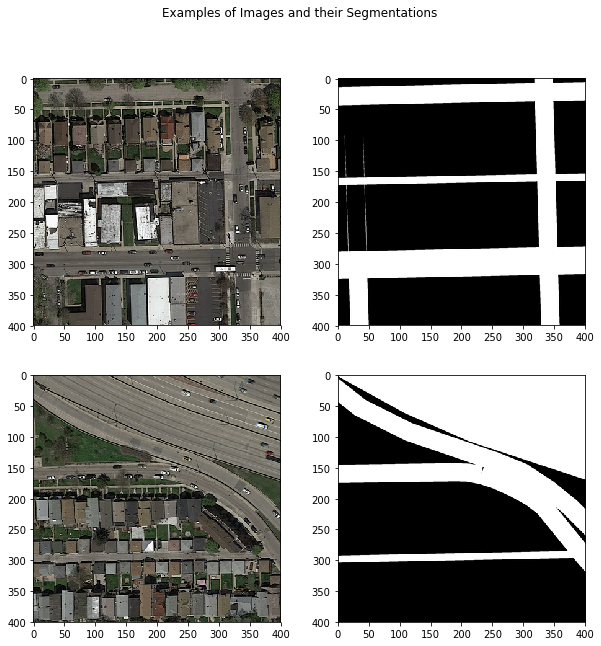

In [6]:
display_num = 2

r_choices = np.random.choice(num_train_examples, display_num)
plt.figure(figsize=(10, 10))

for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = x_train_filenames[img_num]
  y_pathname = y_train_filenames[img_num]

  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname), cmap="gray")  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(mpimg.imread(y_pathname), cmap="gray")

plt.suptitle("Examples of Images and their Segmentations")
plt.show()

# Preprocessing pipeline

In [7]:
img_shape = (256, 256, 3)
batch_size = 3
epochs = 100

In [8]:
def _process_pathnames(fname, label_path):
  """Load the image pair from given paths"""
  # We map this function onto each pathname pair  

  img_str = tf.read_file(fname)
  img = tf.image.decode_png(img_str, channels=3)

  label_img_str = tf.read_file(label_path)
  label_img = tf.image.decode_png(label_img_str, channels=1)
  return img, label_img

## Data augmentation

In [9]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
  """This fn will perform the horizontal or vertical shift"""
  if width_shift_range or height_shift_range:
    if width_shift_range:
      width_shift_range = tf.random_uniform([], 
                                            -width_shift_range * img_shape[1],
                                            width_shift_range * img_shape[1],
                                            seed=753)
    if height_shift_range:
      height_shift_range = tf.random_uniform([],
                                             -height_shift_range * img_shape[0],
                                             height_shift_range * img_shape[0],
                                             seed=753)
    # Translate both 
    output_img = tfcontrib.image.translate(output_img,
                                           [width_shift_range, height_shift_range])
    label_img = tfcontrib.image.translate(label_img,
                                          [width_shift_range, height_shift_range])
  return output_img, label_img

In [10]:
def flip_img(horizontal_flip, tr_img, label_img):
  """Flip the image randomly"""
  if horizontal_flip:
    flip_prob = tf.random_uniform([], 0.0, 1.0, seed=753)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

In [11]:
def rot90_img(rotate90, tr_img, label_img):
  """Rotating the image randomly in 90° angles"""
  if rotate90:
    rotate_count = tf.random_uniform([], 0, 4, dtype=tf.dtypes.int32, seed=753)
    tr_img = tf.image.rot90(tr_img, rotate_count)
    label_img = tf.image.rot90(label_img, rotate_count)

  return tr_img, label_img

In [12]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=False,  # Random left right flip,
             rotate90=False):  # Random number of 90° rotations
  if resize is not None:
    # Resize both images
    label_img = tf.image.resize_images(label_img, resize)
    img = tf.image.resize_images(img, resize)

  if hue_delta:
    img = tf.image.random_hue(img, hue_delta, seed=753)

  img, label_img = flip_img(horizontal_flip, img, label_img)
  img, label_img = rot90_img(rotate90, img, label_img)
  label_img = tf.cast(label_img, tf.dtypes.float32) * scale
  img = tf.cast(img, tf.dtypes.float32) * scale 
  return img, label_img

In [13]:
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True,
                         repeat=True):           
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(_process_pathnames, num_parallel_calls=1)
  
  if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
    assert batch_size == 1, "Batching images must be of the same size"

  dataset = dataset.map(preproc_fn, num_parallel_calls=threads)

  if shuffle:
    dataset = dataset.shuffle(num_x, seed=753)

  # It's necessary to repeat our data for all epochs
  if repeat:
    dataset = dataset.repeat()

  dataset = dataset.batch(batch_size)
    
  return dataset

## Set up train and validation datasets
Note that we apply image augmentation to our training dataset but not our validation dataset. 

In [14]:
tr_cfg = {
  'resize': [img_shape[0], img_shape[1]],
  'scale': 1 / 255.,
  'horizontal_flip': True,
  'rotate90': True,
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [15]:
val_cfg = {
  'resize': [img_shape[0], img_shape[1]],
  'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [16]:
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

Instructions for updating:
Colocations handled automatically by placer.


### Debug Output: Preprocessing pipeline

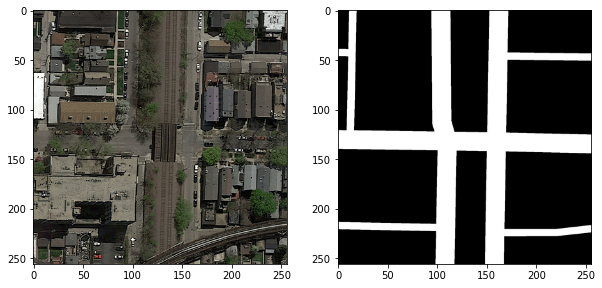

In [17]:
temp_ds = get_baseline_dataset(x_train_filenames, 
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)
# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess: 
  batch_of_imgs, label = sess.run(next_element)

  # Running next element in our graph will produce a batch of images
  plt.figure(figsize=(10, 10))
  img = batch_of_imgs[0]

  plt.subplot(1, 2, 1)
  plt.imshow(img)

  plt.subplot(1, 2, 2)
  plt.imshow(label[0, :, :, 0], cmap='gray')
  plt.show()

# Define our neural network architecture

In [18]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [ ]:
inputs = layers.Input(shape=img_shape)
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

In [ ]:
model = models.Model(inputs=[inputs], outputs=[outputs])

## Define losses

In [ ]:
def dice_coeff(y_true, y_pred):
  smooth = 1.
  # Flatten
  y_true_f = tf.reshape(y_true, [-1])
  y_pred_f = tf.reshape(y_pred, [-1])
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
  return score

In [ ]:
def dice_loss(y_true, y_pred):
  loss = 1 - dice_coeff(y_true, y_pred)
  return loss

In [ ]:
def bce_loss(y_true, y_pred):
  loss = losses.binary_crossentropy(y_true, y_pred)
  return loss

In [ ]:
def root_mean_squared_error(y_true, y_pred):
  loss = tf.sqrt(losses.mean_squared_error(y_true, y_pred))
  return loss

## Compile model

In [ ]:
model.compile(optimizer='adam', 
              loss=dice_loss, 
              metrics=[bce_loss, dice_loss, root_mean_squared_error])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

In [ ]:
save_model_path = 'weights_epoch{epoch:03d}_rmse{val_root_mean_squared_error:.4f}.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_loss', save_best_only=True, verbose=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=1, mode='auto', restore_best_weights=True)

# Train model

In [ ]:
history = model.fit(train_ds, 
                    steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                    epochs=epochs,
                    validation_data=val_ds,
                    validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                    callbacks=[cp, es])

Epoch 1/100
26/27 [===========================>..] - ETA: 0s - loss: 0.6119 - bce_loss: 0.9642 - dice_loss: 0.6119 - root_mean_squared_error: 0.3807
Epoch 00001: val_loss improved from inf to 0.70162, saving model to weights_epoch001_rmse0.7509.hdf5
27/27 [==============================] - 25s 919ms/step - loss: 0.6055 - bce_loss: 0.9605 - dice_loss: 0.6055 - root_mean_squared_error: 0.3767 - val_loss: 0.7016 - val_bce_loss: 2.2336 - val_dice_loss: 0.7016 - val_root_mean_squared_error: 0.7509
Epoch 2/100
26/27 [===========================>..] - ETA: 0s - loss: 0.4973 - bce_loss: 0.9676 - dice_loss: 0.4973 - root_mean_squared_error: 0.2662
Epoch 00002: val_loss did not improve from 0.70162
27/27 [==============================] - 11s 389ms/step - loss: 0.4954 - bce_loss: 0.9666 - dice_loss: 0.4954 - root_mean_squared_error: 0.2654 - val_loss: 0.7864 - val_bce_loss: 0.8055 - val_dice_loss: 0.7864 - val_root_mean_squared_error: 0.3038
Epoch 3/100
26/27 [===========================>..] - E

26/27 [===========================>..] - ETA: 0s - loss: 0.2678 - bce_loss: 0.7605 - dice_loss: 0.2678 - root_mean_squared_error: 0.1011
Epoch 00018: val_loss did not improve from 0.33238
27/27 [==============================] - 11s 404ms/step - loss: 0.2667 - bce_loss: 0.7545 - dice_loss: 0.2667 - root_mean_squared_error: 0.1004 - val_loss: 0.3362 - val_bce_loss: 1.1418 - val_dice_loss: 0.3362 - val_root_mean_squared_error: 0.1405
Epoch 19/100
26/27 [===========================>..] - ETA: 0s - loss: 0.2537 - bce_loss: 0.7474 - dice_loss: 0.2537 - root_mean_squared_error: 0.1004
Epoch 00019: val_loss improved from 0.33238 to 0.27223, saving model to weights_epoch019_rmse0.1131.hdf5
27/27 [==============================] - 12s 444ms/step - loss: 0.2561 - bce_loss: 0.7561 - dice_loss: 0.2561 - root_mean_squared_error: 0.1015 - val_loss: 0.2722 - val_bce_loss: 0.8014 - val_dice_loss: 0.2722 - val_root_mean_squared_error: 0.1131
Epoch 20/100
26/27 [===========================>..] - ETA: 0s

Epoch 36/100
26/27 [===========================>..] - ETA: 0s - loss: 0.2189 - bce_loss: 0.7505 - dice_loss: 0.2189 - root_mean_squared_error: 0.0845
Epoch 00036: val_loss did not improve from 0.20592
27/27 [==============================] - 10s 384ms/step - loss: 0.2165 - bce_loss: 0.7429 - dice_loss: 0.2165 - root_mean_squared_error: 0.0838 - val_loss: 0.2222 - val_bce_loss: 0.7663 - val_dice_loss: 0.2222 - val_root_mean_squared_error: 0.0840
Epoch 37/100
26/27 [===========================>..] - ETA: 0s - loss: 0.2295 - bce_loss: 0.7564 - dice_loss: 0.2295 - root_mean_squared_error: 0.0851
Epoch 00037: val_loss did not improve from 0.20592
27/27 [==============================] - 10s 388ms/step - loss: 0.2324 - bce_loss: 0.7735 - dice_loss: 0.2324 - root_mean_squared_error: 0.0873 - val_loss: 0.5345 - val_bce_loss: 0.9767 - val_dice_loss: 0.5345 - val_root_mean_squared_error: 0.1259
Epoch 38/100
26/27 [===========================>..] - ETA: 0s - loss: 0.2180 - bce_loss: 0.7447 - dice

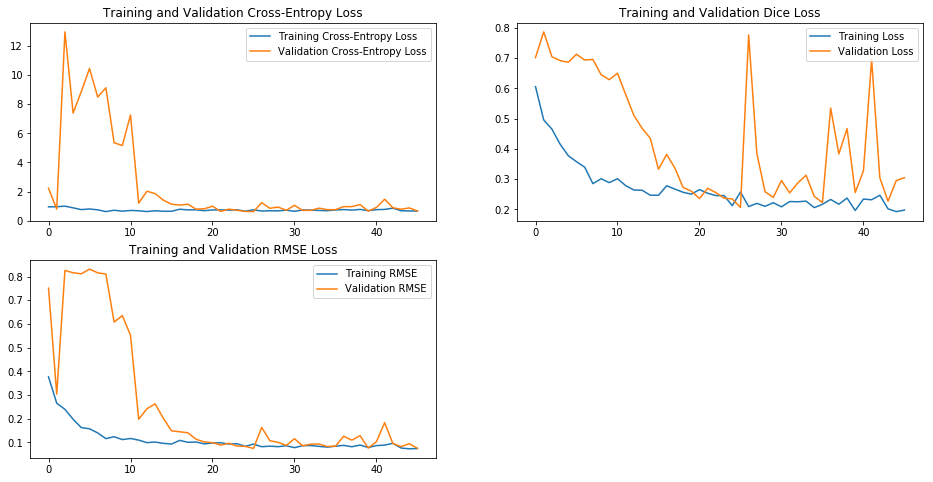

In [ ]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

bce = history.history['bce_loss']
val_bce = history.history['val_bce_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, bce, label='Training Cross-Entropy Loss')
plt.plot(epochs_range, val_bce, label='Validation Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Cross-Entropy Loss')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(2, 2, 3)
plt.plot(epochs_range, rmse, label='Training RMSE')
plt.plot(epochs_range, val_rmse, label='Validation RMSE')
plt.legend(loc='upper right')
plt.title('Training and Validation RMSE Loss')

plt.show()

# Qualitative evaluation of our performance 

In [ ]:
# Load weights from latest checkpoint
model_path = sorted(glob.glob('weights*'), reverse=True)[0]
model = models.load_model(model_path, custom_objects={'root_mean_squared_error': root_mean_squared_error,
                                                           'bce_loss': bce_loss,
                                                           'dice_loss': dice_loss})
# Alternatively, load the weights directly: 
#model.load_weights(model_path)
print("Loaded model from:", model_path)

In [ ]:
# Visualize some of the outputs 
data_aug_iter = val_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))
for i in range(5):
  batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
  img = batch_of_imgs[0]
  predicted_label = model.predict(batch_of_imgs)[0]

  plt.subplot(5, 3, 3 * i + 1)
  plt.imshow(img)
  plt.title("Input image")
  
  plt.subplot(5, 3, 3 * i + 2)
  plt.imshow(label[0, :, :, 0], cmap='gray')
  plt.title("Actual Mask")
  plt.subplot(5, 3, 3 * i + 3)
  plt.imshow(predicted_label[:, :, 0], cmap='gray')
  plt.title("Predicted Mask")
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()

# Create test set predictions

In [ ]:
# create directory for predictions
prediction_dir = model_path
prediction_dir = prediction_dir.replace("weights", "predictions", 1).replace(".hdf5", "", 1)
os.mkdir(prediction_dir)

test_ds = get_baseline_dataset(x_test_filenames,
                               x_test_filenames, 
                               preproc_fn=val_preprocessing_fn,
                               batch_size=batch_size,
                               shuffle=False,
                               repeat=False)

data_aug_iter = test_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
count=0

sess = tf.keras.backend.get_session()
try:
  while True:
    batch_of_imgs, label = sess.run(next_element)
    predicted_labels = model.predict(batch_of_imgs)
    
    # rescale images from [0, 1] to [0, 255]
    predicted_labels = predicted_labels / val_cfg['scale']

    for i in range(len(predicted_labels)):
      pred = Image.fromarray(predicted_labels[i, :, :, 0], 'F').resize((608, 608)).convert('L')
      imageio.imwrite(os.path.join(prediction_dir, test_filenames[count]), pred)
      count += 1

except tf.errors.OutOfRangeError:
  pass

In [ ]:
# Show some of the predictions
display_num = 4

r_choices = np.random.choice(len(test_filenames), display_num)
plt.figure(figsize=(10, 20))

for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = x_test_filenames[img_num]
  y_pathname = os.path.join(prediction_dir, test_filenames[img_num])

  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname), cmap="gray")  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(mpimg.imread(y_pathname), cmap="gray")

plt.suptitle("Examples of images and their predicted segmentations")
plt.show()

### Mask to submission

In [ ]:
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
  df = np.mean(patch)
  if df > foreground_threshold:
    return 1
  else:
    return 0


def mask_to_submission_strings(image_filename):
  """Reads a single image and outputs the strings that should go into the submission file"""
  img_number = int(re.search(r"\d+(?=\.png$)", image_filename).group(0))
  im = mpimg.imread(image_filename)
  patch_size = 16
  for j in range(0, im.shape[1], patch_size):
    for i in range(0, im.shape[0], patch_size):
      patch = im[i:i + patch_size, j:j + patch_size]
      label = patch_to_label(patch)
      yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
  """Converts images into a submission file"""
  with open(submission_filename, 'w') as f:
    f.write('id,prediction\n')
    for fn in image_filenames[0:]:
      f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))

In [ ]:
submission_filename = model_path.replace("weights", "submission", 1).replace(".hdf5", ".csv", 1)
image_filenames = [os.path.join(prediction_dir, filename) for filename in os.listdir(prediction_dir)]
masks_to_submission(submission_filename, *image_filenames)

In [ ]:
print("Validating submission file:", submission_filename)
df = pd.read_csv(submission_filename)

print('Shape of csv:', df.shape)
assert df.shape == (135736, 2), "Invalid number of rows or columns in submission file!"
assert df['id'].unique().size == 135736, "Column 'id' should contain 135736 unique values!"

meanPred = df['prediction'].mean()
print("Mean prediction: {:.3f}".format(meanPred))
assert meanPred > 0.05 and meanPred < 0.3, "Very unlikely mean prediction!"

print("Submission file looks OKAY!")